In [1]:
%reset -fs

In [17]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark.ml.regression import GBTRegressor, RandomForestRegressor, LinearRegression 
from pyspark.ml.evaluation import RegressionEvaluator
pd.set_option('display.max_columns', None)

In [3]:
spark = SparkSession.builder.appName('GCSFilesRead').config("spark.driver.memory", "16g").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/05 18:22:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark._jsc.hadoopConfiguration().set("google.cloud.auth.service.account.json.keyfile","secrets.json")

In [5]:
bucket_name="ndir-metis-bucket"
path=f"gs://{bucket_name}/asteroid/Asteroid_Updated.csv"

In [6]:
df=spark.read.csv(path, sep=',', inferSchema=True, header=True)

# Feature Info
- a: semi-major axis (au)
- e: eccentricity
- i: inclination with respect to ecliptic plane
- om: longitude of the ascending node
- w: argument of perihelion
- q: perihelion distance (au)
- ad: aphelion distance (au)
- per_y: orbital period (years)
- data_arc: span of recorded data (days)
- condition_code: orbital condition code
- n_obs_used: number of observations used
- H: absolute magnitude parameter
- neo: near-earth object
- pha: physically hazardous object
- diameter: diameter (target variable)
- extent: Object bi/tri axial ellipsoid dimensions(Km)
- albedo: geometric albedo
- rot_per: rotation period (hours)
- GM: gravitational parameter. Product of mass and gravitational constant
- BV: Color index B-V magnitude difference
- UB: Color index U-B magnitude difference
- IR: Color index I-R magnitude difference
- specB: Spectral taxonomic type(SMASSII)
- specT: Spectral taxonomic type (Tholen)
- G: Magnitude slope parameter
- moid: Earth minimum orbit intersection distance
- class: asteroid orbit class
- n: mean motion (degrees/day)
- per: orbital period (days)
- ma: mean ananomly (degrees)


In [7]:
def preview(df, n=20):
    return pd.DataFrame(df.take(n), columns=df.columns)
preview(df)

22/04/05 18:23:16 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,name,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,H,neo,pha,diameter,extent,albedo,rot_per,GM,BV,UB,IR,spec_B,spec_T,G,moid,class,n,per,ma
0,Ceres,2.769165,0.076009,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,8822,0,1002,3.34,N,N,939.4,964.4 x 964.2 x 891.8,0.0900,9.074170,62.6284,0.713,0.426,None,C,G,0.12,1.594780,MBA,0.213885,1683.145708,77.372096
1,Pallas,2.772466,0.230337,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,72318,0,8490,4.13,N,N,545,582x556x500,0.1010,7.813200,14.3000,0.635,0.284,None,B,B,0.11,1.233240,MBA,0.213503,1686.155999,59.699133
2,Juno,2.669150,0.256942,12.988919,169.852760,248.138626,1.983332,3.354967,4.360814,72684,0,7104,5.33,N,N,246.596,None,0.2140,7.210000,NaN,0.824,0.433,None,Sk,S,0.32,1.034540,MBA,0.226019,1592.787285,34.925016
3,Vesta,2.361418,0.088721,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,24288,0,9325,3.20,N,N,525.4,572.6 x 557.2 x 446.4,0.4228,5.342128,17.8000,0.782,0.492,None,V,V,0.32,1.139480,MBA,0.271609,1325.432765,95.861936
4,Astraea,2.574249,0.191095,5.366988,141.576605,358.687607,2.082324,3.066174,4.130323,63507,0,2916,6.85,N,N,106.699,None,0.2740,16.806000,NaN,0.826,0.411,None,S,S,NaN,1.095890,MBA,0.238632,1508.600458,282.366289
5,Hebe,2.425160,0.203007,14.737901,138.640203,239.807490,1.932835,2.917485,3.776755,62329,0,6034,5.71,N,N,185.18,None,0.2679,7.274500,NaN,0.822,0.399,None,S,S,0.24,0.973965,MBA,0.260972,1379.459705,86.197923
6,Iris,2.385334,0.231206,5.523651,259.563231,145.265106,1.833831,2.936837,3.684105,62452,0,5206,5.51,N,N,199.83,None,0.2766,7.139000,NaN,0.855,0.484,None,S,S,NaN,0.846100,MBA,0.267535,1345.619196,140.419656
7,Flora,2.201764,0.156499,5.886955,110.889330,285.287462,1.857190,2.546339,3.267115,62655,0,2744,6.49,N,N,147.491,None,0.2260,12.865000,NaN,0.885,0.489,None,None,S,0.28,0.874176,MBA,0.301681,1193.313717,194.882895
8,Metis,2.385637,0.123114,5.576816,68.908577,6.417369,2.091931,2.679342,3.684806,61821,0,2649,6.28,N,N,190,None,0.1180,5.079000,NaN,0.858,0.496,None,None,S,0.17,1.106910,MBA,0.267484,1345.875362,276.861623
9,Hygiea,3.141539,0.112461,3.831560,283.202167,312.315206,2.788240,3.494839,5.568291,62175,0,3409,5.43,N,N,407.12,None,0.0717,27.630000,7.0000,0.696,0.351,None,C,C,NaN,1.778390,MBA,0.177007,2033.818284,152.184851


In [8]:
astro_df = df.dropna(subset=['diameter'])

In [9]:
astro_df = astro_df.drop('extent', 'rot_per', 'GM', 'BV', 'UB', 'IR', 'spec_B', 'spec_T', 'G')

In [10]:
astro_df = astro_df.drop('data_arc', 'H', 'albedo')

In [11]:
astro_df = astro_df.withColumn('neo', regexp_replace('neo', 'Y', 'True'))
astro_df = astro_df.withColumn('neo', regexp_replace('neo', 'N', 'False'))
astro_df = astro_df.withColumn('pha', regexp_replace('pha', 'Y', 'True'))
astro_df = astro_df.withColumn('pha', regexp_replace('pha', 'N', 'False'))

In [12]:
astro_df = astro_df.withColumn('n_obs_used', astro_df['n_obs_used'].cast('double'))

In [13]:
astro_df = astro_df.withColumn('diameter', astro_df['diameter'].cast('double'))

In [14]:
for column in ['neo', 'pha']:
    astro_df = astro_df.withColumn(column, astro_df[column].cast('boolean').cast('int'))

In [15]:
astro_df = astro_df.dropna(subset=['diameter'])

In [18]:
astro_df.toPandas().to_csv('processed_asteroid_data.csv')

In [19]:
condition_code_indexer = StringIndexer(inputCol="condition_code", outputCol="condition_codeIndex")
class_indexer = StringIndexer(inputCol="class", outputCol="classIndex")
onehotencoder_condition_code_vector = OneHotEncoder(inputCol="condition_codeIndex", outputCol="condition_code_vec")
onehotencoder_class_vector = OneHotEncoder(inputCol="classIndex", outputCol="class_vec")

#Create pipeline and pass all stages
encoding_pipeline = Pipeline(stages=[condition_code_indexer,
                            class_indexer,
                            onehotencoder_condition_code_vector,
                            onehotencoder_class_vector
                    ])

In [20]:
astro_df = encoding_pipeline.fit(astro_df).transform(astro_df)

In [21]:
astro_df = astro_df.drop('condition_code', 'class', 'condition_codeIndex', 'classIndex')

In [22]:
astro_df = astro_df.select('name', "a","e","i",'om','w','q','ad', 'per_y', 'n_obs_used', 'neo', 'pha', 'moid', 'n', 'per', 'ma', 'condition_code_vec', 'class_vec', 'diameter')

In [23]:
features = astro_df.schema.names[1:-1]

In [24]:
train, val, test = astro_df.randomSplit([0.6, 0.2, 0.2], seed=42)

In [25]:
train_df = train.drop('name')
val_df = val.drop('name')
test_df = test.drop('name')

In [26]:
assembler = VectorAssembler(inputCols=features, outputCol='features')

In [27]:
test_pack = assembler.transform(test_df)
train_pack = assembler.transform(train_df)
val_pack = assembler.transform(val_df)

In [28]:
for field in features:
    test_pack = test_pack.drop(field)
    train_pack = train_pack.drop(field)
    val_pack = val_pack.drop(field)

In [29]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(train_pack)

train_pack = scaler_model.transform(train_pack)
val_pack = scaler_model.transform(val_pack)
test_pack = scaler_model.transform(test_pack)

In [30]:
gbt = GBTRegressor(featuresCol='features', labelCol='diameter', maxIter=100, maxDepth=5, seed=42, lossType='squared', stepSize=.1)

gbt_model = gbt.fit(train_pack)
gbt_pred = gbt_model.transform(val_pack)

rf = RandomForestRegressor(featuresCol='features', labelCol='diameter', maxDepth=5, seed=42, bootstrap=True, numTrees=100)

rf_model = rf.fit(train_pack)
rf_pred = rf_model.transform(val_pack)

lr = LinearRegression(featuresCol='features', labelCol='diameter', maxIter=100, loss='squaredError', elasticNetParam=0.5, regParam=0.1, fitIntercept=True, standardization=True, solver='auto', tol=.1)

lr_model = lr.fit(train_pack)
lr_pred = lr_model.transform(val_pack)

22/04/05 18:37:43 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/04/05 18:37:43 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [31]:
rmse = RegressionEvaluator(
    labelCol="diameter", predictionCol="prediction", metricName="rmse")

r2 = RegressionEvaluator(
    labelCol="diameter", predictionCol="prediction", metricName="r2")



In [32]:
metrics = [rmse, r2]
metric_labels = ['rmse', 'r2']



In [33]:
predictions = [lr_pred, rf_pred, gbt_pred]
predict_labels = ['LR', 'RF', 'GBT']

In [34]:
eval_list = list()

In [35]:
for pred in zip(predict_labels, predictions):
    name = pred[0]
    predict = pred[1]
    
    metric_vals = pd.Series(dict([(x[0], x[1].evaluate(predict)) 
                                 for x in zip(metric_labels, metrics)]),
                            name=name)
    eval_list.append(metric_vals)
    
# combine all the series into a dataframe
eval_df = pd.concat(eval_list, axis=1).T
eval_df = eval_df[metric_labels]
eval_df

,rmse,r2
LR,7.960936,0.341747
RF,7.738539,0.378012
GBT,7.129790,0.472020


In [36]:
# may take ~5min to run this cell
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# the GradientBoostedTree model
gbt2 = GBTRegressor(featuresCol='features',
                     labelCol='diameter', 
                     predictionCol='prediction',
                     seed=13,
                     lossType='squared',
                     maxIter=100,
                     )
 
pipeline = Pipeline(stages=[gbt2])
# the parameter grid--we'll optimize maxDepth and stepSize
paramgrid = (ParamGridBuilder().addGrid(gbt2.maxDepth, [2,4,6])
                               .addGrid(gbt2.stepSize, [0.0001, 0.001, 0.01, 0.1, 1.0]).build())

# use f1 score as the evaluation metric for best model 
evaluator = RegressionEvaluator(labelCol='diameter', 
                                              predictionCol='prediction', 
                                              metricName='r2') 

In [37]:
crossval = CrossValidator(estimator=pipeline, 
                          estimatorParamMaps=paramgrid, 
                          evaluator=evaluator, 
                          numFolds=3) 

gbt2_model = crossval.fit(train_pack) 

22/04/05 18:43:59 WARN DAGScheduler: Broadcasting large task binary with size 1000.0 KiB
22/04/05 18:43:59 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/04/05 18:43:59 WARN DAGScheduler: Broadcasting large task binary with size 1007.9 KiB
22/04/05 18:44:00 WARN DAGScheduler: Broadcasting large task binary with size 1008.3 KiB
22/04/05 18:44:00 WARN DAGScheduler: Broadcasting large task binary with size 1008.9 KiB
22/04/05 18:44:00 WARN DAGScheduler: Broadcasting large task binary with size 1010.1 KiB
22/04/05 18:44:00 WARN DAGScheduler: Broadcasting large task binary with size 1012.4 KiB
22/04/05 18:44:00 WARN DAGScheduler: Broadcasting large task binary with size 1016.9 KiB
22/04/05 18:44:00 WARN DAGScheduler: Broadcasting large task binary with size 1020.2 KiB
22/04/05 18:44:00 WARN DAGScheduler: Broadcasting large task binary with size 1020.7 KiB
22/04/05 18:44:00 WARN DAGScheduler: Broadcasting large task binary with size 1021.3 KiB
22/04/05 18:44:00 WAR

In [38]:
best_pipeline = gbt2_model.bestModel

In [39]:
best_gbt_model = best_pipeline.stages[0]

In [40]:
len(best_gbt_model.trees)

100

In [41]:
best_gbt_model.trees[:5]

[DecisionTreeRegressionModel: uid=dtr_b978525e8e1b, depth=2, numNodes=7, numFeatures=34,
 DecisionTreeRegressionModel: uid=dtr_af0702e5d2df, depth=2, numNodes=7, numFeatures=34,
 DecisionTreeRegressionModel: uid=dtr_23113b0380ff, depth=2, numNodes=7, numFeatures=34,
 DecisionTreeRegressionModel: uid=dtr_dcc6b06a37c5, depth=2, numNodes=7, numFeatures=34,
 DecisionTreeRegressionModel: uid=dtr_5101a68df967, depth=2, numNodes=7, numFeatures=34]

In [42]:
[x.depth for x in best_gbt_model.trees]

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [43]:
feature_importances = best_gbt_model.featureImportances.toArray()

# extract feature names, except for the predictor
feature_names = astro_df.columns[:-1]

feature_series = (pd.Series(dict(zip(features, feature_importances)))
                  .sort_values(ascending=True))

feature_series

class_vec             0.000000
per_y                 0.000000
condition_code_vec    0.000000
pha                   0.000000
per                   0.000000
w                     0.000047
ma                    0.000492
moid                  0.000665
neo                   0.001809
om                    0.002972
q                     0.011892
ad                    0.016646
i                     0.031209
e                     0.031647
a                     0.043287
n                     0.139154
n_obs_used            0.627156
dtype: float64

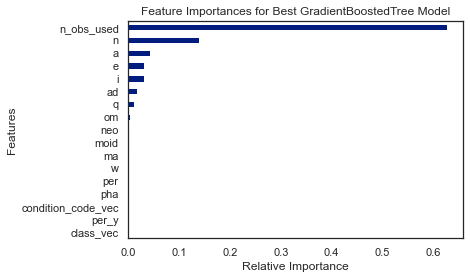

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette('dark')
sns.set_context('notebook')
sns.set_style('white')

ax = feature_series.plot(kind='barh')
_ = ax.set(xlabel='Relative Importance', 
           ylabel='Features', 
           title='Feature Importances for Best GradientBoostedTree Model')

fig = plt.gcf()

# Feature Info
- a: semi-major axis (au)
- e: eccentricity
- i: inclination with respect to ecliptic plane
- om: longitude of the ascending node
- w: argument of perihelion
- q: perihelion distance (au)
- ad: aphelion distance (au)
- per_y: orbital period (years)
- data_arc: span of recorded data (days)
- condition_code: orbital condition code
- n_obs_used: number of observations used
- H: absolute magnitude parameter
- neo: near-earth object
- pha: physically hazardous object
- diameter: diameter (target variable)
- extent: Object bi/tri axial ellipsoid dimensions(Km)
- albedo: geometric albedo
- rot_per: rotation period (hours)
- GM: gravitational parameter. Product of mass and gravitational constant
- BV: Color index B-V magnitude difference
- UB: Color index U-B magnitude difference
- IR: Color index I-R magnitude difference
- specB: Spectral taxonomic type(SMASSII)
- specT: Spectral taxonomic type (Tholen)
- G: Magnitude slope parameter
- moid: Earth minimum orbit intersection distance
- class: asteroid orbit class
- n: mean motion (degrees/day)
- per: orbital period (days)
- ma: mean ananomly (degrees)


In [45]:
gbt_pred_test = best_pipeline.transform(test_pack)

In [46]:
predictions = [lr_pred, rf_pred, gbt_pred, gbt_pred_test]
predict_labels = ['LR', 'RF', 'GBT', 'GBT_GridSearch']

In [47]:
eval_list = []
for pred in zip(predict_labels, predictions):
    name = pred[0]
    predict = pred[1]
    
    metric_vals = pd.Series(dict([(x[0], x[1].evaluate(predict)) 
                                 for x in zip(metric_labels, metrics)]),
                            name=name)
    eval_list.append(metric_vals)
    
# combine all the series into a dataframe
eval_df = pd.concat(eval_list, axis=1).T
eval_df = eval_df[metric_labels]
eval_df

,rmse,r2
LR,7.960936,0.341747
RF,7.738539,0.378012
GBT,7.129790,0.472020
GBT_GridSearch,6.783630,0.442609


22/04/06 01:11:09 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1066192 ms exceeds timeout 120000 ms
22/04/06 01:11:09 WARN SparkContext: Killing executors is not supported by current scheduler.
